# Chapter 6

## ch6.1
### MNIST 학습하기

#### tensorflow에서 기본으로 제공하는 mnist 예제를 사용

`No module named 'tensorflow.examples.tutorials'` 에러는 [tensorflow github](https://github.com/tensorflow/tensorflow) 에서 `tensorflow/tensorflow/examples` 경로의 파일들을 `...Python설치경로/Lib/site-packages` 에 복사하면 해결 할 수 있다.

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


#### 모델 구성

In [2]:
X = tf.placeholder(tf.float32, [None, 784]) # 28*28 픽셀 이므로 784개의 특징을 가짐
Y = tf.placeholder(tf.float32, [None, 10]) # 레이블 (0~9)

#### 아래와 같은 신경망으로 구성
#### 784(입력, 특징 개수) -> 256(첫 번째 은닉층 뉴런 개수) -> 256(두 번째 은닉층 뉴런 개수)-> 10(결과값 0~9 분류 개수)

In [3]:
W1 = tf.Variable(tf.random_normal([784,256],stddev=0.01))
L1 = tf.nn.relu(tf.matmul(X, W1))

W2 = tf.Variable(tf.random_normal([256,256],stddev=0.01))
L2 = tf.nn.relu(tf.matmul(L1, W2))

W3 = tf.Variable(tf.random_normal([256, 10], stddev=0.01))
model = tf.matmul(L2,W3)

In [4]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model,labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#### 미니배치의 크기를 100개로 설정

In [6]:
batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

#### 학습을 15번 반복 학습, 데이터 전체를 학습하는 것을 에포크라고 한다.
#### 결과 출력

In [7]:
for epoch in range(15):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images,Y:mnist.test.labels}))

Epoch: 0001 Avg. cost = 0.399
Epoch: 0002 Avg. cost = 0.146
Epoch: 0003 Avg. cost = 0.096
Epoch: 0004 Avg. cost = 0.071
Epoch: 0005 Avg. cost = 0.053
Epoch: 0006 Avg. cost = 0.042
Epoch: 0007 Avg. cost = 0.034
Epoch: 0008 Avg. cost = 0.029
Epoch: 0009 Avg. cost = 0.020
Epoch: 0010 Avg. cost = 0.016
Epoch: 0011 Avg. cost = 0.015
Epoch: 0012 Avg. cost = 0.017
Epoch: 0013 Avg. cost = 0.011
Epoch: 0014 Avg. cost = 0.012
Epoch: 0015 Avg. cost = 0.011
최적화 완료
정확도: 0.9786



## ch6.2
### 드롭아웃
- 드롭아웃은 학습 시 전체 신경망 중 일부만을 사용하도록 하는 것
- 학습 단계마다 일부 뉴런을 제거 함으로써, 일부 특징이 특정 뉴런들에 고정되는 것을 막아 가중치의 균형을 잡도록 하여 과적합을 방지
- 일부 뉴런을 학습시키지 않기 때문에 신경망이 충분히 학습되기까지의 시간은 조금더 오래 걸리는 편

In [8]:
keep_prob = tf.placeholder(tf.float32) # 학습시에는 드롭아웃으로 80프로의 뉴런만 사용하고 예측시에는 전체를 사용해주기 위해 선언

W1 = tf.Variable(tf.random_normal([784,256],stddev=0.01))
L1 = tf.nn.relu(tf.matmul(X, W1))
#L1 = tf.nn.dropout(L1, 0.8) # 학습시 80프로의 뉴런을 사용한다는 의미
L1 = tf.nn.dropout(L1, keep_prob)

W2 = tf.Variable(tf.random_normal([256,256],stddev=0.01))
L2 = tf.nn.relu(tf.matmul(L1, W2))
L2 = tf.nn.dropout(L2, keep_prob)

W3 = tf.Variable(tf.random_normal([256, 10], stddev=0.01))
model = tf.matmul(L2,W3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model,labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(30):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.8})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images,Y:mnist.test.labels,keep_prob: 1}))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch: 0001 Avg. cost = 0.434
Epoch: 0002 Avg. cost = 0.165
Epoch: 0003 Avg. cost = 0.117
Epoch: 0004 Avg. cost = 0.088
Epoch: 0005 Avg. cost = 0.073
Epoch: 0006 Avg. cost = 0.061
Epoch: 0007 Avg. cost = 0.052
Epoch: 0008 Avg. cost = 0.046
Epoch: 0009 Avg. cost = 0.041
Epoch: 0010 Avg. cost = 0.038
Epoch: 0011 Avg. cost = 0.034
Epoch: 0012 Avg. cost = 0.030
Epoch: 0013 Avg. cost = 0.029
Epoch: 0014 Avg. cost = 0.029
Epoch: 0015 Avg. cost = 0.028
Epoch: 0016 Avg. cost = 0.023
Epoch: 0017 Avg. cost = 0.025
Epoch: 0018 Avg. cost = 0.022
Epoch: 0019 Avg. cost = 0.021
Epoch: 0020 Avg. cost = 0.021
Epoch: 0021 Avg. cost = 0.020
Epoch: 0022 Avg. cost = 0.019
Epoch: 0023 Avg. cost = 0.019
Epoch: 0024 Avg. cost = 0.018
Epoch: 0025 Avg. cost = 0.020
Epoch: 0026 Avg. cost = 0.016
Epoch: 0027 Avg. cost = 0.017
Epoch: 0028 Avg. cost = 0.016
Epoch: 0029 Avg. cost = 0.016
Epoch: 0030 Avg


## ch6.3
### matplotlib
#### matplotlib 으로 결과 확인

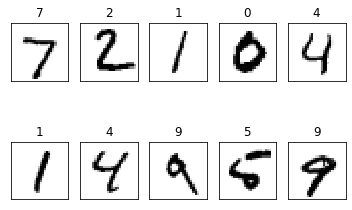

In [9]:
labels = sess.run(model,feed_dict={X: mnist.test.images,Y: mnist.test.labels, keep_prob:1})
fig = plt.figure()

for i in range(10):
    subplot = fig.add_subplot(2,5,i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),cmap=plt.cm.gray_r)

plt.show()